This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

In [1]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai

# Import package

In [2]:
import os
import requests
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [3]:
%load_ext autoreload
%autoreload 2

import llm_geo.LLM_Geo_Constants as constants
import llm_geo.helper as helper

from llm_geo.LLM_Geo_kernel import Solution

# Demonstration Cases

## Input task and data desciption

In [7]:
isReview = True

In [5]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 


# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]


# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
model=r"gpt-4o"
# model = r'gpt-4-turbo-preview'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please d

## Get graph code from GPT API

In [6]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# 1. Load hazardous waste site shapefile
G.add_node("haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="Hazardous waste facility shapefile URL")
G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile")
G.add_edge("haz_waste_shp_url", "load_haz_waste_shp")
G.add_node("haz_waste_gdf", node_type="data", data_path="", description="Hazardous waste facility GeoDataFrame")
G.add_edge("load_haz_waste_shp", "haz_waste_gdf")

# 2. Load NC tract boundary shapefile
G.add_node("tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="NC tract boundary shapefile URL")
G.add_node("load_tract_shp", node_type="operation", description="Load NC tract boundary shapefile")
G.add_edge("tract_shp_url", "load_tract_shp")
G.add_node("tract_gdf", node_type="data", data_path="", description="NC tract boundary GeoDataFrame")
G.add_edge("load_tract_shp", "tract_gdf")

# 3. Load NC tract population CSV file
G.add_node("pop_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="NC tract population CSV URL")
G.add_node("load_pop_csv", node_type="operation", description="Load NC tract population CSV")
G.add_edge("pop_csv_url", "load_pop_csv")
G.add_node("pop_df", node_type="data", data_path="", description="NC tract population DataFrame")
G.add_edge("load_pop_csv", "pop_df")

# 4. Join population data with tract geometries
G.add_node("join_pop_tracts", node_type="operation", description="Join population data with tract geometries")
G.add_edge("tract_gdf", "join_pop_tracts")
G.add_edge("pop_df", "join_pop_tracts")
G.add_node("tracts_pop_gdf", node_type="data", data_path="", description="Tract GeoDataFrame with population data")
G.add_edge("join_pop_tracts", "tracts_pop_gdf")

# 5. Find Census tracts containing hazardous waste facilities
G.add_node("find_haz_tracts", node_type="operation", description="Find Census tracts containing hazardous waste facilities")
G.add_edge("haz_waste_gdf", "find_haz_tracts")
G.add_edge("tracts_pop_gdf", "find_haz_tracts")
G.add_node("haz_tracts_gdf", node_type="data", data_path="", description="Tract GeoDataFrame containing hazardous waste facilities")
G.add_edge("find_haz_tracts", "haz_tracts_gdf")

# 6. Compute and print population in those tracts
G.add_node("compute_population", node_type="operation", description="Compute population in hazardous waste containing tracts")
G.add_edge("haz_tracts_gdf", "compute_population")
G.add_node("pop_in_haz_tracts", node_type="data", data_path="", description="Population in hazardous waste containing tracts")
G.add_edge("compute_population", "pop_in_haz_tracts")

# 7. Generate and save a population choropleth map with highlighted tracts
G.add_node("generate_choropleth", node_type="operation", description="Generate population choropleth map")
G.add_edge("tracts_pop_gdf", "generate_choropleth")
G.add_edge("haz_tracts_gdf", "generate_choropleth")
G.add_node("choropleth_map", node_type="data", data_path="", description="Population choropleth map with highlighted tracts")
G.add_edge("generate_choropleth", "choropleth_map")

# Saving the graph to GraphML format
nx.write_graphml(G, "d:/code/github/LLM-Geo/Resident_at_risk_counting/Resident_at_risk_counting.graphml")

## Execute code to generate the solution graph

In [7]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
x = nt.show(name=html_name)

d:\code\github\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [8]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    # Description: Load hazardous waste facility shapefile
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf
import geopandas as gpd

def load_tract_shp(tract_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    # Description: Load NC tract boundary shapefile from a given URL
    # tract_shp_url: NC tract boundary shapefile URL
    tract_gdf = gpd.read_file(tract_shp_url)
    return tract_gdf
import pandas as pd

def load_pop_csv(pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """
    Load NC tract population CSV

    Parameters:
    pop_csv_url (str): URL to the NC tract population CSV file

    Returns:
    pop_df (pd.DataFrame): DataFrame containing the loaded population data
    """
    pop_df = pd.read_csv(pop_csv_url, dtype={'GEOID': int, 'TotalPopulation': int})
    pop_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    return pop_df
import pandas as pd
import geopandas as gpd

def join_pop_tracts(tract_gdf, pop_df):
    """
    Join population data with tract geometries.

    Parameters:
    tract_gdf (gpd.GeoDataFrame): GeoDataFrame containing tract geometries
    pop_df (pd.DataFrame): DataFrame containing population data

    Returns:
    tracts_pop_gdf (gpd.GeoDataFrame): GeoDataFrame with joined population data
    """
    # Drop rows with NaN values in relevant columns
    tract_gdf.dropna(subset=['GEOID'], inplace=True)
    pop_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    
    # Ensure the GEOID fields are of the same type for joining purposes
    tract_gdf['GEOID'] = tract_gdf['GEOID'].astype(int).astype(str)
    pop_df['GEOID'] = pop_df['GEOID'].astype(int).astype(str)
    
    # Join the population DataFrame with the tract GeoDataFrame
    tracts_pop_gdf = tract_gdf.merge(pop_df, on='GEOID', how='left')
    
    return tracts_pop_gdf
import geopandas as gpd

def find_haz_tracts(haz_waste_gdf, tracts_pop_gdf):
    """
    Find Census tracts containing hazardous waste facilities.

    Parameters:
    haz_waste_gdf (gpd.GeoDataFrame): GeoDataFrame containing hazardous waste facility data
    tracts_pop_gdf (gpd.GeoDataFrame): GeoDataFrame containing tract geometries and population data

    Returns:
    haz_tracts_gdf (gpd.GeoDataFrame): GeoDataFrame containing tracts that have hazardous waste facilities
    """
    # Ensure both GeoDataFrames are in the same projection
    if haz_waste_gdf.crs != tracts_pop_gdf.crs:
        haz_waste_gdf = haz_waste_gdf.to_crs(tracts_pop_gdf.crs)
    
    # Perform spatial join to find tracts containing hazardous waste facilities
    joined_gdf = gpd.sjoin(tracts_pop_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    
    # Remove duplicate tracts if any
    haz_tracts_gdf = joined_gdf.drop_duplicates(subset=['GEOID'])
    
    return haz_tracts_gdf
def compute_population(haz_tracts_gdf):
    """
    Compute population in hazardous waste containing tracts

    Parameters:
    haz_tracts_gdf (gpd.GeoDataFrame): GeoDataFrame containing tracts that have hazardous waste facilities

    Returns:
    pop_in_haz_tracts (int): Total population in hazardous waste containing tracts
    """
    
    # Dropping rows with NaN values in the relevant columns
    haz_tracts_gdf.dropna(subset=['TotalPopulation'], inplace=True)
    
    # Compute the total population in hazardous waste containing tracts
    pop_in_haz_tracts = haz_tracts_gdf['TotalPopulation'].sum()
    
    return pop_in_haz_tracts
import matplotlib.pyplot as plt
import geopandas as gpd

def generate_choropleth(tracts_pop_gdf, haz_tracts_gdf):
    """
    Generate population choropleth map for all tract polygons in NC, rendering the color by tract population;
    and then highlight the borders 

## Generate prompts and code for assembly program

In [9]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    # Description: Load hazardous waste facility shapefile
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf

def load_tract_shp(tract_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    # Description: Load NC tract boundary shapefile from a given URL
    tract_gdf = gpd.read_file(tract_shp_url)
    return tract_gdf

def load_pop_csv(pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """
    Load NC tract population CSV

    Parameters:
    pop_csv_url (str): URL to the NC tract population CSV file

    Returns:
    pop_df (pd.DataFrame): DataFrame containing the loaded population data
    """
    pop_df = pd.read_csv(pop_csv_url, dtype={'GEOID': int, 'TotalPopulation': int})
    pop_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    return pop_df

def join_pop_tracts(tract_gdf, pop_df):
    """
    Join population data with tract geometries.

    Parameters:
    tract_gdf (gpd.GeoDataFrame): GeoDataFrame containing tract geometries
    pop_df (pd.DataFrame): DataFrame containing population data

    Returns:
    tracts_pop_gdf (gpd.GeoDataFrame): GeoDataFrame with joined population data
    """
    # Drop rows with NaN values in relevant columns
    tract_gdf.dropna(subset=['GEOID'], inplace=True)
    pop_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    
    # Ensure the GEOID fields are of the same type for joining purposes
    tract_gdf['GEOID'] = tract_gdf['GEOID'].astype(int).astype(str)
    pop_df['GEOID'] = pop_df['GEOID'].astype(int).astype(str)
    
    # Join the population DataFrame with the tract GeoDataFrame
    tracts_pop_gdf = tract_gdf.merge(pop_df, on='GEOID', how='left')
    
    return tracts_pop_gdf

def find_haz_tracts(haz_waste_gdf, tracts_pop_gdf):
    """
    Find Census tracts containing hazardous waste facilities.

    Parameters:
    haz_waste_gdf (gpd.GeoDataFrame): GeoDataFrame containing hazardous waste facility data
    tracts_pop_gdf (gpd.GeoDataFrame): GeoDataFrame containing tract geometries and population data

    Returns:
    haz_tracts_gdf (gpd.GeoDataFrame): GeoDataFrame containing tracts that have hazardous waste facilities
    """
    # Ensure both GeoDataFrames are in the same projection
    if haz_waste_gdf.crs != tracts_pop_gdf.crs:
        haz_waste_gdf = haz_waste_gdf.to_crs(tracts_pop_gdf.crs)
    
    # Perform spatial join to find tracts containing hazardous waste facilities
    joined_gdf = gpd.sjoin(tracts_pop_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    
    # Remove duplicate tracts if any
    haz_tracts_gdf = joined_gdf.drop_duplicates(subset=['GEOID'])
    
    return haz_tracts_gdf

def compute_population(haz_tracts_gdf):
    """
    Compute population in hazardous waste containing tracts

    Parameters:
    haz_tracts_gdf (gpd.GeoDataFrame): GeoDataFrame containing tracts that have hazardous waste facilities

    Returns:
    pop_in_haz_tracts (int): Total population in hazardous waste containing tracts
    """
    
    # Dropping rows with NaN values in the relevant columns
    haz_tracts_gdf.dropna(subset=['TotalPopulation'], inplace=True)
    
    # Compute the total population in hazardous waste containing tracts
    pop_in_haz_tracts = haz_tracts_gdf['TotalPopulation'].sum()
    
    return pop_in_haz_tracts

def generate_choropleth(tracts_pop_gdf, haz_tracts_gdf):
    """
    Generate population choropleth map for all tract polygons in NC, rendering the color by tract population;
    and then highlight the borders of tracts that have hazardous waste facilities.

    Parameters:
    tracts_pop_gdf (gpd.GeoDataFrame): GeoDataFrame containing tract geometries and population data
   

## Execute assembly code



-------------- Running code (trial # 1/10) --------------


Total population in hazardous waste containing tracts: 5683893


--------------- Done ---------------




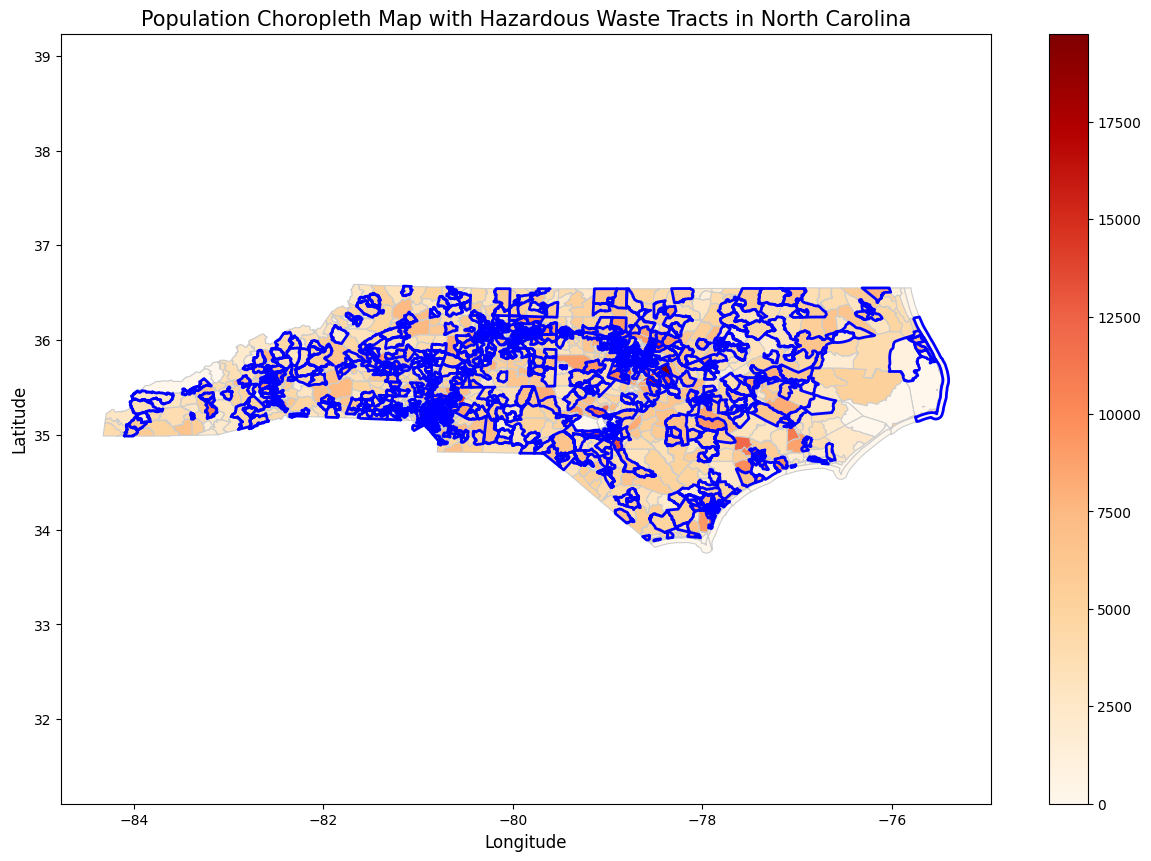

In [10]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)